<a href="https://colab.research.google.com/github/lilywright99/scRNAseqtutorial/blob/main/Day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Whole Network Entropy** (**Day 3**)

# **IMPORTANT!** Before we begin, change runtime type to R

### **1. Load in data**

In [1]:
exp_data <- read.csv('/content/X.csv', header=FALSE)
metadata <-read.csv('/content/obs.csv')
var_data<- read.csv('/content/var.csv')

rownames(exp_data)<-metadata$CellID
colnames(exp_data)<-var_data$Gene


### **2. Create Metadata and Expression data for the 3 cell types; Secretory Epithelial-1, Secretory Epithelial-2, STIC lesion**

In [2]:
install.packages("dplyr")
library(dplyr)
metadata_SE1 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-1'),]
exp_data_SE1 <- exp_data[rownames(exp_data) %in% metadata_SE1$CellID,]

metadata_SE2 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-2'),]
exp_data_SE2 <- exp_data[rownames(exp_data) %in% metadata_SE2$CellID,]

metadata_STIC <- metadata[metadata$Celltype %in% c('STIC lesion'),]
exp_data_STIC <- exp_data[rownames(exp_data) %in% metadata_STIC$CellID,]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### **3. Entropy Analysis**

From the expression data of each cell type we would sample 50 genes and calculate the entropy of the expression levels of the 50 genes. Sampling will be iterated 100 times. Finally a boxplot will be plotted to represent the 100 entropy values in each cell type.


*   **Entropy**: Entropy quantifies the amount of uncertainty or randomness in information content. Introduced by Claude Shannon, it is the average number of bits required to encode a message or the unpredictability of a data source.

  - High entropy: A message is highly unpredictable or random
  
  - Low entropy: A message is predictable or repetitive
  - Example: A fair coin flip has 1 bit of entropy per flip because there are two equally likely outcomes (heads or tails).
*   **Sampling/Subsampling**: A technique used to extract a smaller subset of data (a "subsample") from a larger sample or dataset. It is often employed to reduce computational complexity, test robustness, or handle large datasets efficiently without analyzing the entire sample.

* **Purpose**: To provide better coverage of the network. Calculating a single entropy of the entire network could mask clusters/areas of very high or low entropy.

In [4]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("BioQC")
library(BioQC)

exp_data_SE1 <- t(exp_data_SE1)
exp_data_SE2 <- t(exp_data_SE2)
exp_data_STIC <- t(exp_data_STIC)

compilation_SE1 <- data.frame()

for (x in 1:100) {
  n <- sample(1:nrow(exp_data_SE1), 50, replace=FALSE)
  test <- exp_data_SE1[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_SE1 <- rbind(compilation_SE1, samples)
}

compilation_SE2 <- data.frame()

for (x in 1:100) {
  n <- sample(1:nrow(exp_data_SE2), 50, replace=FALSE)
  test <- exp_data_SE2[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_SE2 <- rbind(compilation_SE2, samples)
}

compilation_STIC <- data.frame()

for (x in 1:100) {
  n <- sample(1:nrow(exp_data_STIC), 50, replace=FALSE)
  test <- exp_data_STIC[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_STIC <- rbind(compilation_STIC, samples)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'BioQC'

also installing the dependencies ‘statmod’, ‘BiocGenerics’, ‘limma’, ‘locfit’, ‘Biobase’, ‘edgeR’


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grep

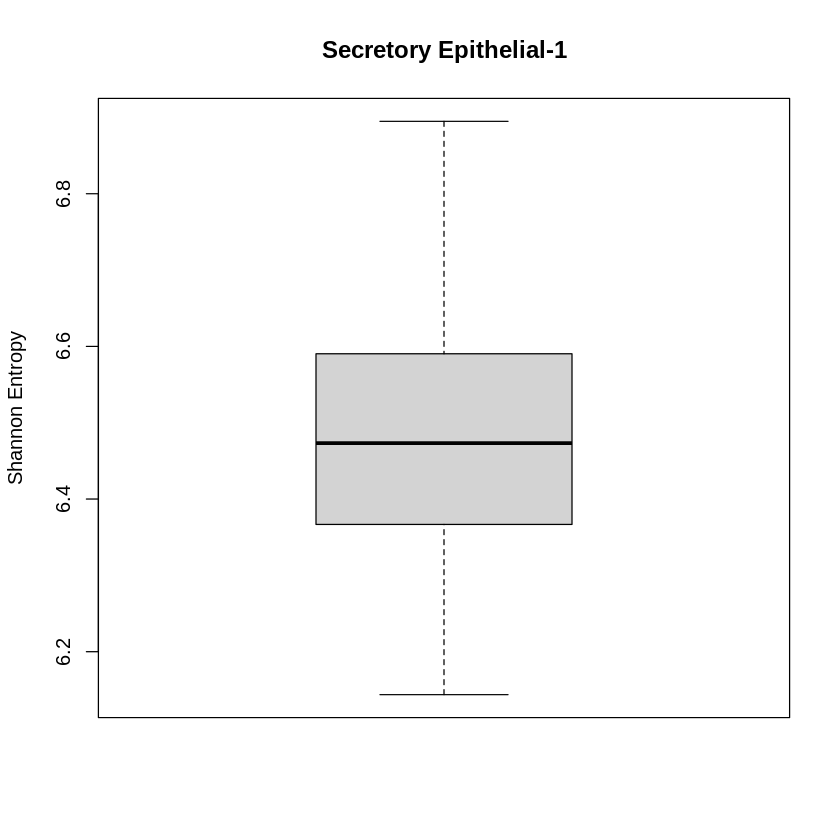

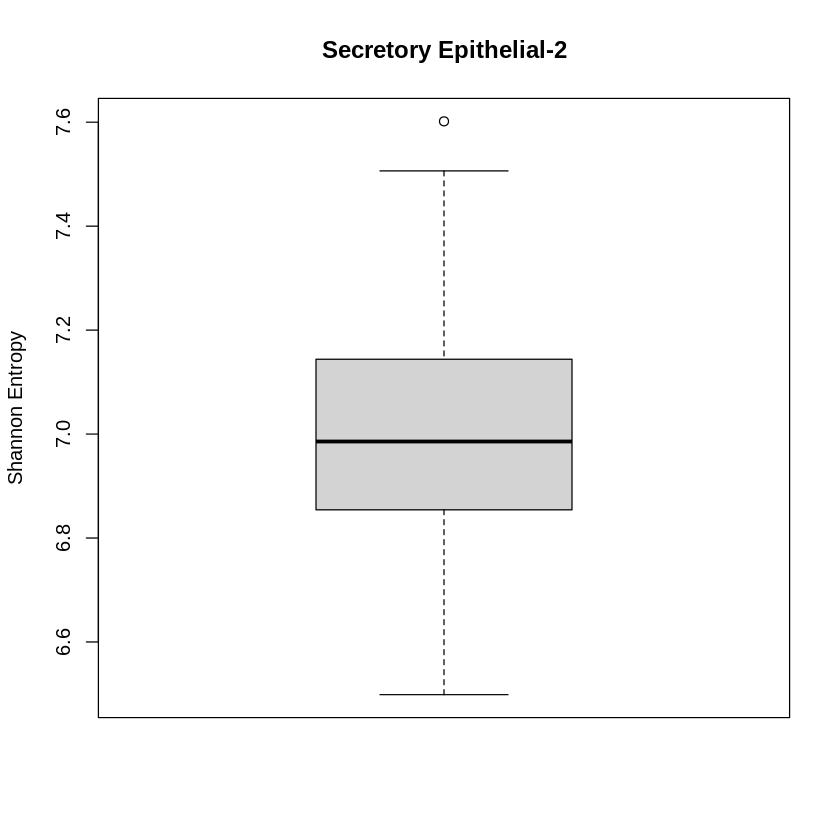

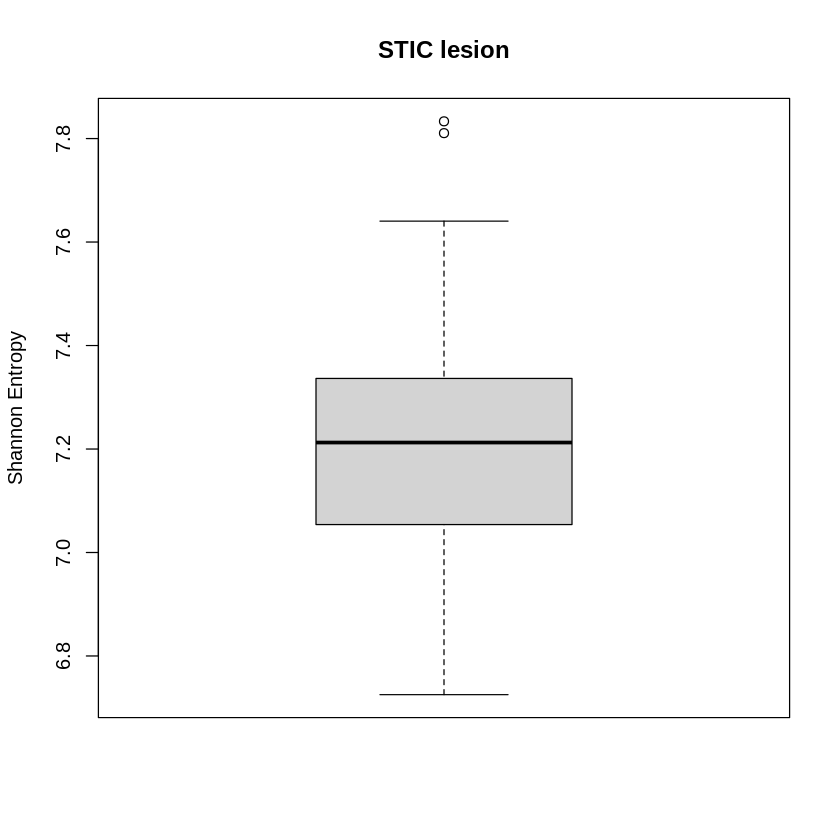

In [5]:
colnames(compilation_SE1) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_SE1$Entropy,
        main="Secretory Epithelial-1",
        ylab="Shannon Entropy")

colnames(compilation_SE2) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_SE2$Entropy,
        main="Secretory Epithelial-2",
        ylab="Shannon Entropy")

colnames(compilation_STIC) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_STIC$Entropy,
        main="STIC lesion",
        ylab="Shannon Entropy")

### **4. Bayesian Analysis**

Select 2 cell types to determine how different they are based on the entropy values.

* **Bayesian Statistics**: An approach to statistical inference that uses probability to quantify uncertainty and incorporates prior knowledge or beliefs into the analysis. This framework contrasts with frequentist statistics, which relies solely on observed data without incorporating prior beliefs. Bayesian methods are particularly useful in situations involving uncertainty, limited data, or complex models.

  - Prior Distribution: Represents initial beliefs about parameters before observing data.
Can be subjective (based on expert knowledge) or non-informative (flat or uniform to express no strong initial belief).
  - Likelihood : Describes how likely the observed data is, assuming a particular hypothesis.
  - Posterior Distribution: Combines the prior and likelihood to provide the updated belief about the hypothesis.
  - Bayesian Updating: As new data is observed, the posterior from one analysis becomes the prior for the next. This iterative process refines estimates over time.

In [28]:
install.packages("BayesFactor")
library(BayesFactor)

bayes_SE1 <-  ttestBF(x= compilation_SE1$Entropy, posterior = TRUE ,iterations = 1000)

bayes_STIC <-  ttestBF(x= compilation_STIC$Entropy, posterior = TRUE ,iterations = 1000)

bayes_SE1_STIC <-  ttestBF(x= compilation_STIC$Entropy, y=compilation_SE1$Entropy,
                           posterior = TRUE ,iterations = 1000, paired = TRUE)

post_SE1<- data.frame(mu = as.numeric(bayes_SE1[,"mu"]), Posterior = 'Secretory Epithelial-1')
post_STIC<- data.frame(mu = as.numeric(bayes_STIC[,"mu"]), Posterior = 'STIC lesion')
post_SE1_STIC<- data.frame(mu = as.numeric(bayes_SE1_STIC[,"mu"]), Posterior = 'Secretory Epithelial-1 & STIC lesion')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Plot Posterior distribution**

* **Confidence Interval**: This is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence. The interval is defined by the confidence level, which is the percentage of times you expect to reproduce an estimate between the upper and lower bounds of the confidence interval. Here The confidence level is set at 95%, thus you can be confident that 95 out of 100 times the estimate will fall between the upper and lower values specified by the confidence interval.

In [10]:
install.packages("HDInterval")
library(HDInterval)
ci95<-hdi(post_SE1_STIC)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


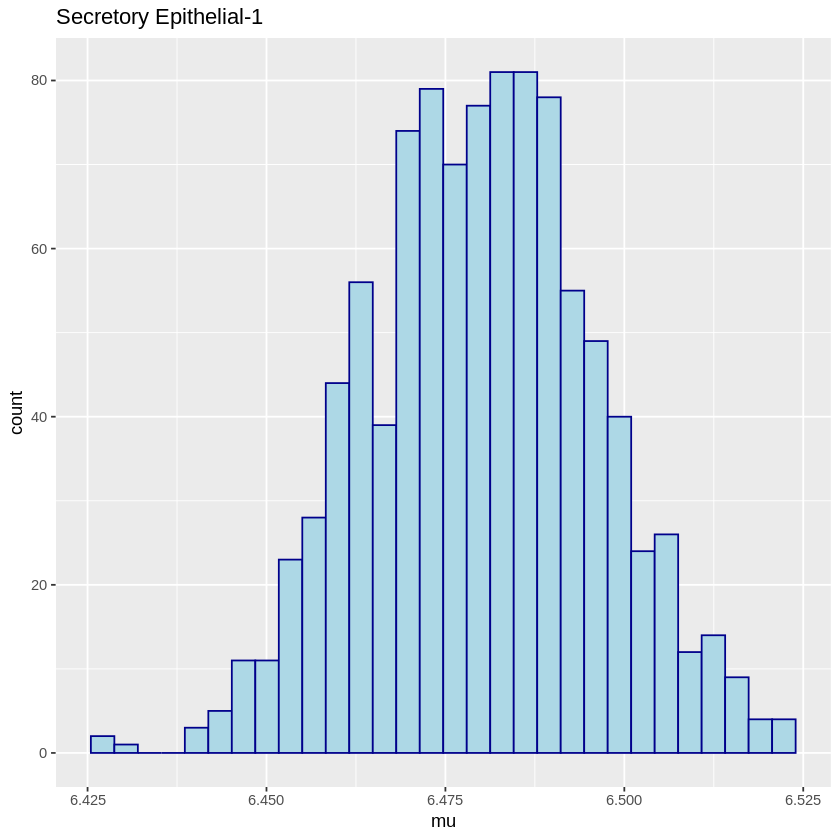

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


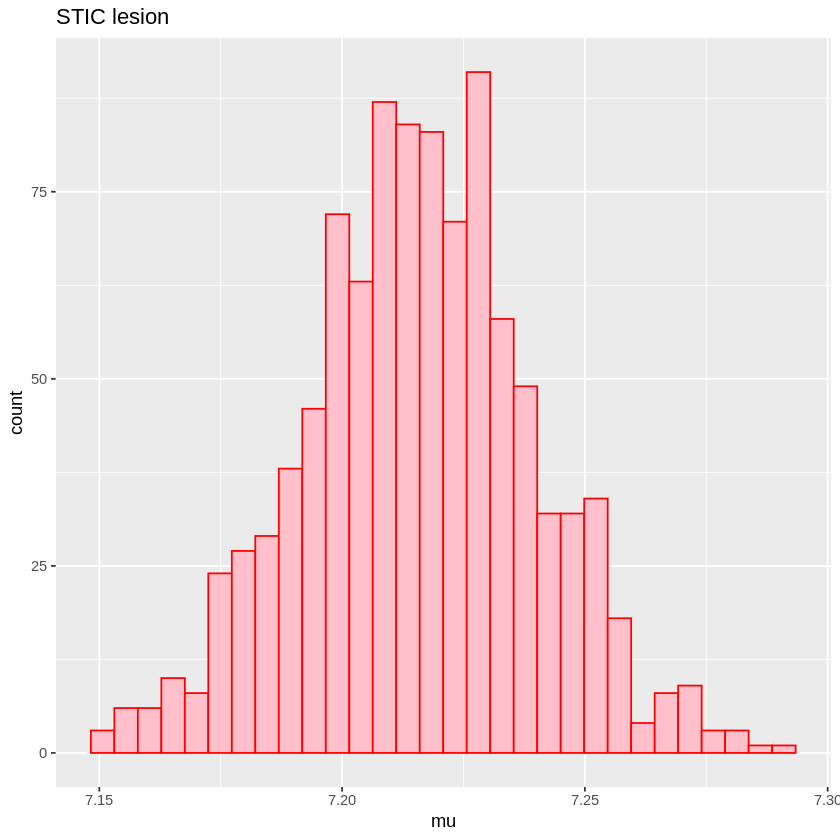

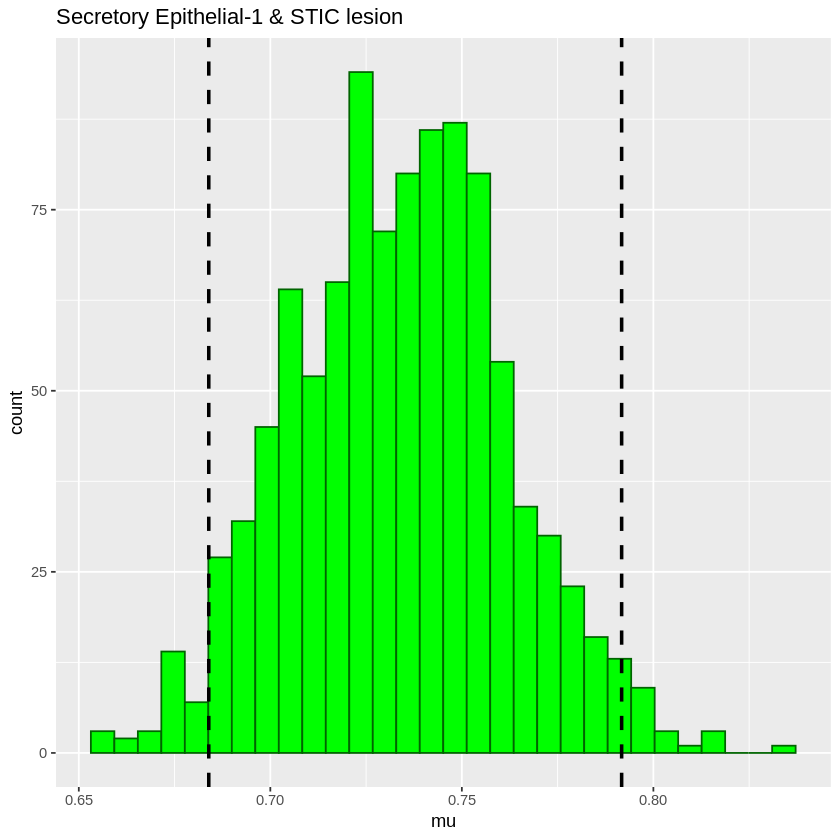

In [27]:
install.packages("ggplot2")
library(ggplot2)

plot_post_SE1 <- ggplot(post_SE1, aes(x=mu))+
  geom_histogram(color="darkblue", fill="lightblue") +
  ggtitle("Secretory Epithelial-1")

plot_post_STIC <- ggplot(post_STIC, aes(x=mu))+
  geom_histogram(color="red", fill="pink") +
  ggtitle("STIC lesion")

plot_post_SE1_STIC <- ggplot(post_SE1_STIC, aes(x=mu))+
  geom_histogram(color="darkgreen", fill="green") +
  geom_vline(xintercept = as.numeric(ci95[1:2]), linetype="dashed",
             color = "black", size=1, ) +
  ggtitle("Secretory Epithelial-1 & STIC lesion")


plot_post_SE1
plot_post_STIC
plot_post_SE1_STIC

# **Try Part 4 and Part 5 yourself with a different combination of the 2 cell types**

Select 2 cell types for analysis. Replace "choice" to selected cell types.

In [ ]:
bayes_Choice1 <-  ttestBF(x= compilation_Choice1$Entropy, posterior = TRUE ,iterations = 1000)
plot(bayes_Choice1[,"mu"])

bayes_Choice2 <-  ttestBF(x= compilation_Choice2$Entropy, posterior = TRUE ,iterations = 1000)
plot(bayes_Choice2[,"mu"])

bayes_Choice1_Choice2 <-  ttestBF(x= compilation_Choice1$Entropy, y=compilation_Choice2$Entropy,
                           posterior = TRUE ,iterations = 1000, paired = TRUE)

post_Choice1<- data.frame(mu = as.numeric(bayes_Choice1[,"mu"]), Posterior = 'Choice 1')
post_Choice2<- data.frame(mu = as.numeric(bayes_Choice2[,"mu"]), Posterior = 'Choice 2')
post_Choice1_Choice2<- data.frame(mu = as.numeric(bayes_Choice1_Choice2[,"mu"]), Posterior = 'Choice 1 & Choice 2')

In [ ]:
library(HDInterval)
ci95<-hdi(post_Choice1_Choice2)

library(ggplot2)

plot_post_Choice1 <- ggplot(post_Choice1, aes(x=mu))+
  geom_histogram(color="darkblue", fill="lightblue")+
  ggtitle("Choice1")

plot_post_Choice2 <- ggplot(post_Choice2, aes(x=mu))+
  geom_histogram(color="red", fill="pink")+
  ggtitle("Choice2")

plot_post_Choice1_Choice2 <- ggplot(post_Choice1_Choice2, aes(x=mu))+
  geom_histogram(color="darkgreen", fill="green") +
  geom_vline(xintercept = ci95, linetype="dashed",
             color = "black", size=1, )+
  ggtitle("Choice1 & Choice2")

plot_post_Choice1
plot_post_Choice2
plot_post_Choice1_Choice2